In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import georinex as gr
import xarray as xr
from scipy.constants import c

import pathlib
import subprocess

In [2]:
def mask_zeros(x):
    return x.where(x != 0)

In [3]:
def load(path):
    x = gr.load(path)
    params = ['BGDe5a', 'BGDe5b', 'SVclockBias', 'DataSrc']
    return x[params].sel(sv = [sv for sv in x.sv.values if sv.startswith('E')])

data = pathlib.Path('data_new')
rnx = xr.concat((load(r) for r in data.glob('*.rnx')), dim = 'time')

In [4]:
gal_sv = sorted({sv[:3] for sv in rnx.sv.values if sv.startswith('E') and sv[:3] not in ['E14', 'E18']})

def aliases(svn):
    return [sv for sv in rnx.sv.values if sv.startswith(svn)]

In [5]:
before = slice('2020-09-01', '2020-09-29')
after = slice('2020-10-01', '2020-10-31')
means_e5a_before = [1e9*mask_zeros(rnx['BGDe5a'].sel(sv = aliases(svn), time = before)).mean() for svn in gal_sv]
stds_e5a_before = [1e9*mask_zeros(rnx['BGDe5a'].sel(sv = aliases(svn), time = before)).std() for svn in gal_sv]
means_e5b_before = [1e9*mask_zeros(rnx['BGDe5b'].sel(sv = aliases(svn), time = before)).mean() for svn in gal_sv]
stds_e5b_before = [1e9*mask_zeros(rnx['BGDe5b'].sel(sv = aliases(svn), time = before)).std() for svn in gal_sv]
means_e5a_after = [1e9*mask_zeros(rnx['BGDe5a'].sel(sv = aliases(svn), time = after)).mean() for svn in gal_sv]
stds_e5a_after = [1e9*mask_zeros(rnx['BGDe5a'].sel(sv = aliases(svn), time = after)).std() for svn in gal_sv]
means_e5b_after = [1e9*mask_zeros(rnx['BGDe5b'].sel(sv = aliases(svn), time = after)).mean() for svn in gal_sv]
stds_e5b_after = [1e9*mask_zeros(rnx['BGDe5b'].sel(sv = aliases(svn), time = after)).std() for svn in gal_sv]

/home/daniel/.local/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/daniel/.local/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


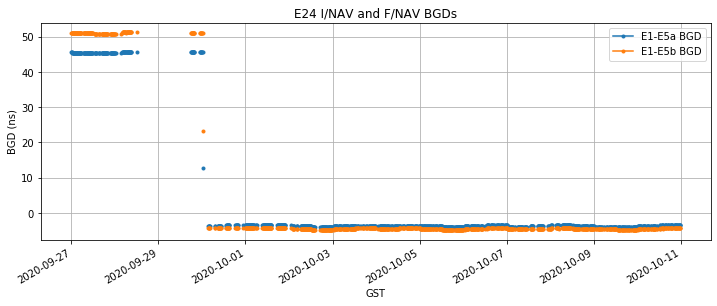

In [6]:
E24_e5a = 1e9*mask_zeros(rnx['BGDe5a'].sel(sv = aliases('E24'))).mean('sv')
E24_e5b = 1e9*mask_zeros(rnx['BGDe5b'].sel(sv = aliases('E24'))).mean('sv')
plt.figure(figsize = (12,4), facecolor = 'w')
E24_e5a.plot(marker = '.')
E24_e5b.plot(marker = '.')
plt.grid()
plt.ylabel('BGD (ns)')
plt.xlabel('GST')
plt.title('E24 I/NAV and F/NAV BGDs')
plt.legend(['E1-E5a BGD', 'E1-E5b BGD']);

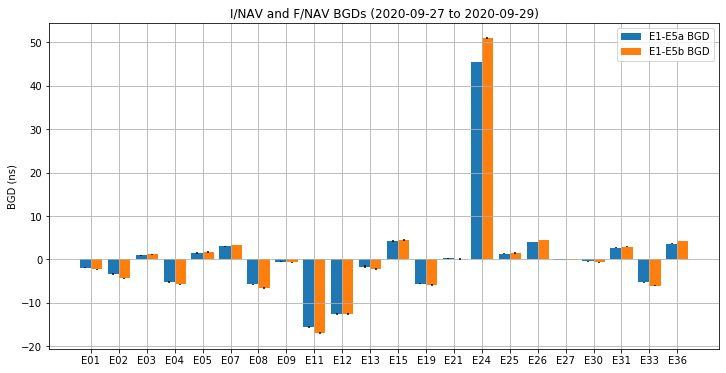

In [7]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.bar(np.arange(len(means_e5a_before))-0.2, means_e5a_before, yerr = stds_e5a_before, width = 0.4)
plt.bar(np.arange(len(means_e5b_before))+0.2, means_e5b_before, yerr = stds_e5b_before, width = 0.4)
plt.xticks(np.arange(len(means_e5a_before)), gal_sv)
plt.grid()
plt.legend(['E1-E5a BGD', 'E1-E5b BGD'])
plt.title(f'I/NAV and F/NAV BGDs (2020-09-27 to 2020-09-29)')
plt.ylabel('BGD (ns)');

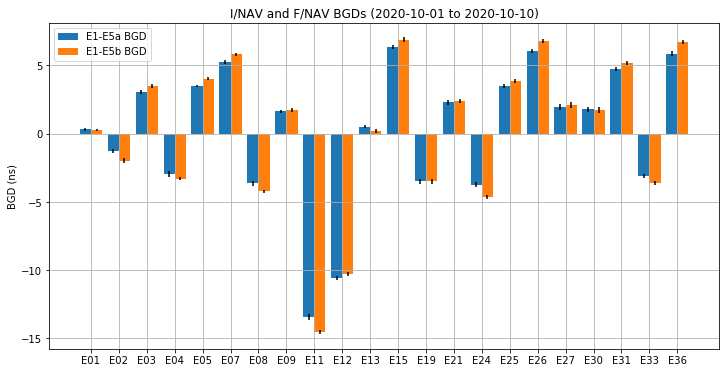

In [8]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.bar(np.arange(len(means_e5a_after))-0.2, means_e5a_after, yerr = stds_e5a_after, width = 0.4)
plt.bar(np.arange(len(means_e5b_after))+0.2, means_e5b_after, yerr = stds_e5b_after, width = 0.4)
plt.xticks(np.arange(len(means_e5a_after)), gal_sv)
plt.grid()
plt.legend(['E1-E5a BGD', 'E1-E5b BGD'])
plt.title(f'I/NAV and F/NAV BGDs (2020-10-01 to 2020-10-10)')
plt.ylabel('BGD (ns)');

In [9]:
def is_gal(x):
    return len(x) == 3 and x[0] == 'E'

dsb = list()
for p in data.glob('*.BSX'):
    with open(p) as f:
        dsb.extend([l for l in f if l.startswith(' DSB') and is_gal(l.split()[2])])
        
dsb_before = list()
for p in list(data.glob('*2020271*.BSX')) + list(data.glob('*2020272*.BSX')):
    with open(p) as f:
        dsb_before.extend([l for l in f if l.startswith(' DSB') and is_gal(l.split()[2])])

dsb_after = list()
for p in [a for j in range(3,10) for a in list(data.glob(f'*202027{j}*.BSX'))] + list(data.glob('*202028*.BSX')):
    with open(p) as f:
        dsb_after.extend([l for l in f if l.startswith(' DSB') and is_gal(l.split()[2])])

In [10]:
gal_sv_all = sorted({s.split()[2] for s in dsb})
sigs = ['C5Q', 'C6C', 'C7Q', 'C8Q']

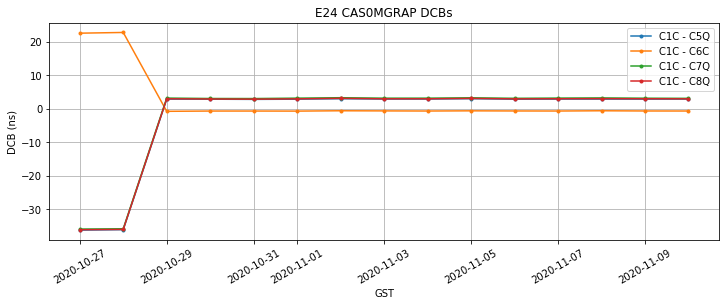

In [11]:
plt.figure(figsize = (12,4), facecolor = 'w')
for j,sig in enumerate(sigs):
    dat = np.array([[float(x) for x in s.split()[-2:]] for s in dsb if s.split()[2] == 'E24' and s.split()[4] == sig])
    plt.plot(np.datetime64('2020-10-27') + np.arange(dat.shape[0]) * np.timedelta64(1, 'D'),
             dat[:,0], '.-', label = f'C1C - {sig}')
plt.legend()
plt.grid()
plt.xticks(rotation = 30)
plt.xlabel('GST')
plt.ylabel('DCB (ns)')
plt.title('E24 CAS0MGRAP DCBs');

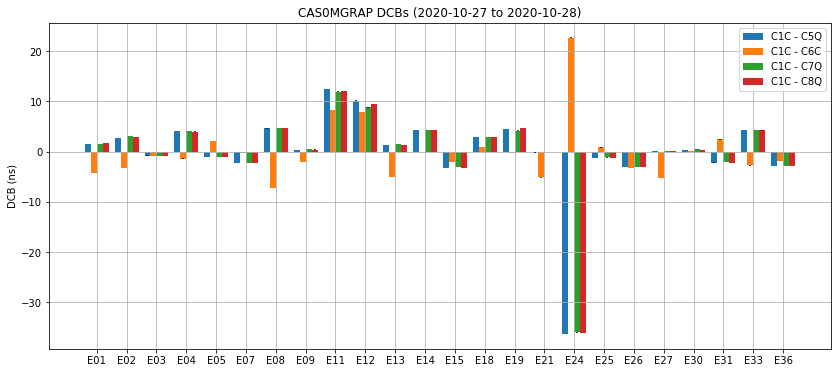

In [12]:
plt.figure(figsize = (14,6), facecolor = 'w')
for j,sig in enumerate(sigs):
    dat = np.array([[[float(x) for x in s.split()[-2:]] for s in dsb_before if s.split()[2] == svn and s.split()[4] == sig] for svn in gal_sv_all])
    means = np.average(dat[...,0], axis = -1)
    stds = np.sqrt(np.sum(dat[...,1]**2, axis = -1))/dat.shape[1]
    plt.bar(np.arange(len(means))-0.2*1.5+j*0.2, means, yerr = stds, width = 0.2)
plt.xticks(np.arange(len(means)), gal_sv_all)
plt.grid()
plt.legend([f'C1C - {sig}' for sig in sigs])
plt.title(f'CAS0MGRAP DCBs (2020-10-27 to 2020-10-28)')
plt.ylabel('DCB (ns)');

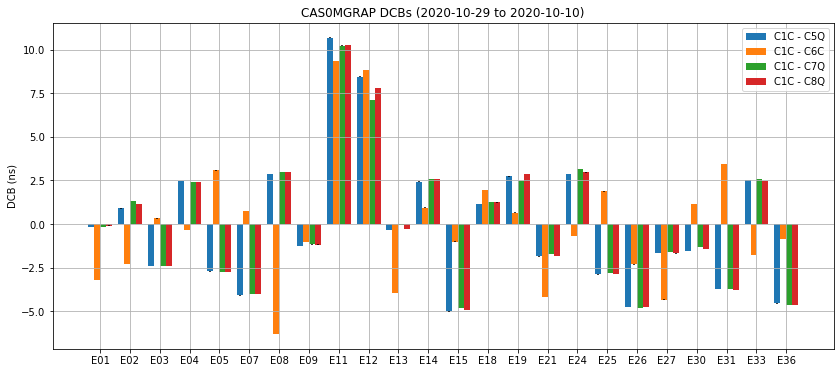

In [13]:
plt.figure(figsize = (14,6), facecolor = 'w')
for j,sig in enumerate(sigs):
    dat = np.array([[[float(x) for x in s.split()[-2:]] for s in dsb_after if s.split()[2] == svn and s.split()[4] == sig] for svn in gal_sv_all])
    means = np.average(dat[...,0], axis = -1)
    stds = np.sqrt(np.sum(dat[...,1]**2, axis = -1))/dat.shape[1]
    plt.bar(np.arange(len(means))-0.2*1.5+j*0.2, means, yerr = stds, width = 0.2)
plt.xticks(np.arange(len(means)), gal_sv_all)
plt.grid()
plt.legend([f'C1C - {sig}' for sig in sigs])
plt.title(f'CAS0MGRAP DCBs (2020-10-29 to 2020-10-10)')
plt.ylabel('DCB (ns)');